In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import netCDF4

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os, warnings


import os
os.getcwd()

%cd /home/599/ars599/Documents/a10/

/home/599/ars599/Documents/a10


In [2]:
# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.yt_ocean
  lon=indat.xt_ocean

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     lon=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(yt_ocean=iplat,xt_ocean=iplon).weighted(wgt).mean(("xt_ocean", "yt_ocean"), skipna=True)
  return(odat)

# --- tz tg
'''
    tztg(dataset, temperature name in dataset); not finish
'''
def tztg(ds):
    temp_all = ds.pot_temp
    if np.max( temp_all ) > 250:
        temp_all - 273.15
    area_t = ds.area_t
    dzh = ds.dht

    zero = temp_all - temp_all # create a 3D mask
    vol = np.multiply( dzh, area_t ) + zero
    t_vol = np.multiply( temp_all + zero, vol )

    x1 = np.sum(np.sum(np.sum(t_vol,axis = 3),axis = 2),axis = 1) 
    x2 = np.sum(np.sum(np.sum(vol,axis = 3),axis = 2),axis = 1)
    tg = np.divide(x1, x2)

    x1 = np.sum(np.sum(t_vol,axis = 3),axis = 2)
    x2 = np.sum(np.sum(vol,axis = 3),axis = 2)
    tz = np.divide(x1, x2)
    return(tz, tg)

def lonFlipbyXarray(xarraydata, lonname = 'lon', to360 = True):
    '''
    https://pythonmana.com/2022/245/202209021515330046.html
    针对xarray数据将lon从-180:180转为0:360
    :param xarraydata: xarray类型数据, lon:-180:180
    :param lonname: 数据中lon坐标名，默认为lon
    :param to360: True: 将数据从-180:180 转换成0:360 False：将数据从0:360转换成-180:180
    :return: xarraydataFlip
    '''
    if to360:
        xarraydata.coords[lonname] = (xarraydata.coords[lonname] + 180) % 360 - 180
    else:
        xarraydata.coords[lonname] = (1 - (xarraydata.coords[lonname] + 180) // 180) * 180 + (
        xarraydata.coords[lonname] + 180) % 180

    xarraydataFlip = xarraydata.sortby(xarraydata.xt_ocean) # 这句如果lonname不是lon需要相应修改
    return xarraydataFlip


In [3]:
expt1="HI-00"
expt2="HI-02"
variable="temp"
session = None # cc.database.create_session()
ncfile='ocean.nc'

RUNDIR = '/g/data/p66/ars599/access-esm/archive/'
fName = '/output0*/ocean/ocean_month.nc'
ds1 = xr.open_mfdataset(RUNDIR+expt1+fName,combine = 'nested', concat_dim="time")
ds2 = xr.open_mfdataset(RUNDIR+expt2+fName,combine = 'nested', concat_dim="time")

import glob
print(glob.glob(RUNDIR+expt2+fName)) 

['/g/data/p66/ars599/access-esm/archive/HI-02/output021/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output014/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output002/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output015/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output001/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output012/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output005/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output013/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output011/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output008/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output024/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output017/ocean/ocean_month.nc', '/g/data/p66/ars599/access-esm/archive/HI-02/output010/ocean/oc

In [4]:
# calculate TG & TZ
date = ds1.time
yyyy = date.time.dt.year
mm = date.time.dt.month
dd = date.time.dt.day
yyyymmdd = yyyy+(mm-1)/12+dd/365

tztg1 = tztg(ds1)
tztg2 = tztg(ds2)

tz1 = tztg1[0]
tg1 = tztg1[1]
tz2 = tztg2[0]
tg2 = tztg2[1]

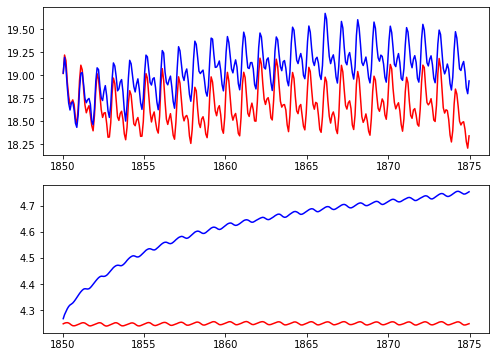

In [5]:
fig = plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot( yyyymmdd, tz1.isel(st_ocean=0) ,"r",label="TZ:"+expt1)
plt.plot( yyyymmdd, tz2.isel(st_ocean=0) ,"b",label="TZ:"+expt2)
plt.subplot(2,1,2)
plt.plot( yyyymmdd, tg1 ,"r",label="TG:"+expt1)
plt.plot( yyyymmdd, tg2 ,"b",label="TG:"+expt2)

In [6]:
# read in observation data
RUNDIR1 = '/g/data/ik11/observations/woa13/10_KDS50/'
rName = 'woa13_ts_*'

ds0 = xr.open_mfdataset(RUNDIR1+rName,decode_times=False)
sst_WOA13 = ds0.temp.isel(ZT=0).mean('time')
if np.max( sst_WOA13 ) > 250:
    sst_WOA13 - 273.15

In [11]:
sst_00   = ds1.pot_temp.isel(st_ocean=0).mean('time')
sst_01   = ds2.pot_temp.isel(st_ocean=0).mean('time')
sst_bias1  = sst_00 - sst_WOA13.values
sst_bias2  = sst_01 - sst_WOA13.values
sst_diff12 = sst_00 - sst_01

latS = -65.
latN =  65.
lonL = -70.
lonR = 140.
bias1 = sst_bias1.sel(yt_ocean=slice(latS, latN), xt_ocean=slice(lonL, lonR))
bias2 = sst_bias2.sel(yt_ocean=slice(latS, latN), xt_ocean=slice(lonL, lonR))
biasd = sst_diff12.sel(yt_ocean=slice(latS, latN), xt_ocean=slice(lonL, lonR))

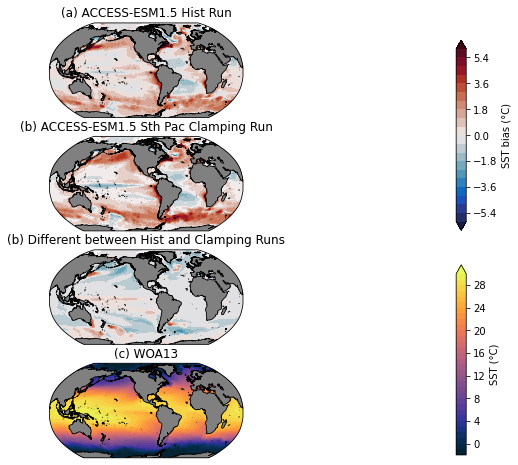

In [12]:
# plotting
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec

plt.figure(figsize=(14,10))
clev = np.arange(-6,6.01,0.6)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)
# Create 2x3 sub plots
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, :],projection=ccrs.Robinson(central_longitude=-100))
ax1.coastlines(resolution='50m')
ax1.add_feature(land_50m)
p1 = sst_bias1.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('(a) ACCESS-ESM1.5 Hist Run')

ax2 = plt.subplot(gs[1, :],projection=ccrs.Robinson(central_longitude=-100))
ax2.coastlines(resolution='50m')
ax2.add_feature(land_50m)
p2 = sst_bias2.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('(b) ACCESS-ESM1.5 Sth Pac Clamping Run')

ax3 = plt.subplot(gs[2, :],projection=ccrs.Robinson(central_longitude=-100))
ax3.coastlines(resolution='50m')
ax3.add_feature(land_50m)
p3 = sst_diff12.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('(b) Different between Hist and Clamping Runs')

ax4 = plt.subplot(gs[3, :],projection=ccrs.Robinson(central_longitude=-100))
ax4.coastlines(resolution='50m')
ax4.add_feature(land_50m)
p4 = sst_WOA13.plot.contourf(cmap=cm.cm.thermal,levels=np.arange(-2,30.01,1),add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('(c) WOA13')

ax5 = plt.axes([0.82,0.52,0.01,0.33]) # y-pos x-pos (up)
cb = plt.colorbar(p1,cax=ax5,orientation='vertical')
cb.ax.set_ylabel('SST bias (°C)')

ax6 = plt.axes([0.82,0.13,0.01,0.33]) # y-pos x-pos (down)
cb = plt.colorbar(p4,cax=ax6,orientation='vertical')
cb.ax.set_ylabel('SST (°C)')

#savefigure('by647c_sst_bias')
plt.show()

In [ ]:
# Nino34